# Importing Libraries

In [2]:
! pip install biosppy   

     |████████████████████████████████| 85 kB 1.4 MB/s eta 0:00:011
  Created wheel for biosppy: filename=biosppy-0.7.3-py2.py3-none-any.whl size=95409 sha256=74f20e6914b8eafd929347ef37b53c25cf6304b8652a00bcf0695cd19ec47270
  Stored in directory: /root/.cache/pip/wheels/2f/4f/8f/28b2adc462d7e37245507324f4817ce1c64ef2464f099f4f0b
Successfully built biosppy


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import wfdb
import os                                                                                                  
import gc
import scipy       
import sklearn
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import preprocessing
import shutil
import math
import random
from scipy.spatial import distance
from biosppy.signals import ecg
from scipy.interpolate import PchipInterpolator

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.0.0.2:8470']


# Dataset Creation

## MIT-BIH Dataset

In [5]:
####### Dataset Creation  
###### Reading Dataset

##### Function to read a record from single dataset
def data_read_mit(filepath):
    
    """
    Function to read the the inputs from MIT-BIH Dataset
    INPUTS:- 
    1)filepath: Path to the csv file
    
    OUTPUTS:-
    1)Output_signal: Output 1D array signal 
    """
    return (np.array(pd.read_csv(filepath,index_col=0).iloc[:,[0]]))   
    
##### Function to Required Annotations from .txt files
def feature_extractor(txt_file_path):
    
    """
       Function to extract time series data 
       from a .txt file
    """
    
    #### Reading File
    line_list = []

    with open(txt_file_path, 'r') as reader:

    # Read and print the entire file line by line
        line = reader.readline()
        while line != '':  # The EOF char is an empty string
            #print(line, end='')
            line_list.append(line)
            line = reader.readline()
    
    #### Taking the Time Step Data
    line_list = line_list[1:]
    
    #### Splitting the Collected Text Strings and Converting them into Floating type values
    new_list = []

    for item in line_list:
        for idx,sub_item in enumerate(item.split()):
            if(idx == 1):
                new_list.append(int(sub_item))
                break
    
    ### Returning the feature extracted list as numpy array
    return np.array(new_list)

###### Function to Segment Signals
##### Constants
FS = 500
W_LEN = 256
W_LEN_1_4 = 256 // 4
W_LEN_3_4 = 3 * (256 // 4)

##### Function
def segmentSignals(signal, r_peaks_annot, normalization=True, person_id= None, file_id=None):
    
    """
    Segments signals based on the detected R-Peak
    Args:
        signal (numpy array): input signal
        r_peaks_annot (int []): r-peak locations.
        normalization (bool, optional): apply z-normalization or not? . Defaults to True.
        person_id ([type], optional): [description]. Defaults to None.
        file_id ([type], optional): [description]. Defaults to None.
    Returns:
            [tuple(numpy array,numpy array)]: segmented signals and refined r-peaks
    """
    def refine_rpeaks(signal, r_peaks):
        """
        Refines the detected R-peaks. If the R-peak is slightly shifted, this assigns the 
        highest point R-peak.
        Args:
            signal (numpy array): input signal
            r_peaks (int []): list of detected r-peaks
        Returns:
            [numpy array]: refined r-peaks
        """

        r_peaks2 = np.array(r_peaks)            # make a copy
        for i in range(len(r_peaks)):
            r = r_peaks[i]          # current R-peak
            small_segment = signal[max(0,r-100):min(len(signal),r+100)]         # consider the neighboring segment of R-peak
            r_peaks2[i] = np.argmax(small_segment) - 100 + r_peaks[i]           # picking the highest point
            r_peaks2[i] = min(r_peaks2[i],len(signal))                          # the detected R-peak shouldn't be outside the signal
            r_peaks2[i] = max(r_peaks2[i],0)                                    # checking if it goes before zero    
        return r_peaks2                     # returning the refined r-peak list
    
    segmented_signals = []                      # array containing the segmented beats
    
    r_peaks = np.array(r_peaks_annot)
    r_peaks = refine_rpeaks(signal, r_peaks)
    skip_len = 5 # Parameter to specify number of r_peaks in one signal
    max_seq_len = 1280 # Parameter to specify maximum sequence length
    
    for r_curr in range(0,int(r_peaks.shape[0]-(skip_len-1)),skip_len):
        if ((r_peaks[r_curr]-W_LEN_1_4)<0) or ((r_peaks[r_curr+(skip_len-1)]+W_LEN_3_4)>=len(signal)):           # not enough signal to segment
            continue
        segmented_signal = np.array(signal[r_peaks[r_curr]-W_LEN_1_4:r_peaks[r_curr+(skip_len-1)]+W_LEN_3_4])        # segmenting a heartbeat
        segmented_signal = list(segmented_signal)
        #print(segmented_signal.shape)
        
        if(len(segmented_signal) < 1280):
            for m in range(int(1280-len(segmented_signal))): # Zero Padding
                segmented_signal.append(0)
        else:
            segmented_signal = (segmented_signal[:int(max_seq_len)])
            
        segmented_signal = np.array(segmented_signal)
        
        if(segmented_signal.shape != (1280,1)):    
            segmented_signal = np.reshape(segmented_signal,(1280,1))
            
        if (normalization):             # Z-score normalization
            if abs(np.std(segmented_signal))<1e-6:          # flat line ECG, will cause zero division error
                continue
            segmented_signal = (segmented_signal - np.mean(segmented_signal)) / np.std(segmented_signal)            
              
        #if not np.isnan(segmented_signal).any():                    # checking for nan, this will never happen
            segmented_signals.append(segmented_signal)

    return segmented_signals,r_peaks           # returning the segmented signals and the refined r-peaks

In [6]:
###### Looping for Reading the Entire Dataset - OpenSet Testing

! mkdir './5_Beat_Ecg_MITBIH_1' # Generating major database of datasets
current_index = 1

mit_dbs_path = '../input/mitbih-database'
for i in range(0,96,2): # Loop over all the files
    print(i)
    print(np.sort(os.listdir(mit_dbs_path))[i])
    rec_file_path = os.path.join(mit_dbs_path,str(np.sort(os.listdir(mit_dbs_path))[i])) # Path Selection
    attr_file_path = os.path.join(mit_dbs_path,str(np.sort(os.listdir(mit_dbs_path))[i+1])) # Path Selction
    
    signal_current = data_read_mit(rec_file_path) # Current ECG Signal
    r_peaks_current = feature_extractor(attr_file_path) # R-peaks
    seg_signal_current,new_r_peaks = (segmentSignals(signal_current,list(r_peaks_current))) # Segmented ECG Signals
    #seg_signal_current = np.array(seg_signal_current)
    #print(seg_signal_current.shape[0])
    
    if(i == 48):
        current_index = current_index-1
        current_storage_path = './5_Beat_Ecg_MITBIH_1'+'/person'+str(current_index)
        #Path(current_storage_path).mkdir(parents=True, exist_ok=True)
    
        for j in range(len(seg_signal_current)):
            file_name_current = current_storage_path+'/Extra'+str(j)
            np.savez_compressed(file_name_current,seg_signal_current[j])
            
        current_index = current_index+1
    
    else:
        current_storage_path = './5_Beat_Ecg_MITBIH_1'+'/person'+str(current_index)
        Path(current_storage_path).mkdir(parents=True, exist_ok=True)
    
        for j in range(len(seg_signal_current)):
            file_name_current = current_storage_path+'/'+str(j)
            np.savez_compressed(file_name_current,seg_signal_current[j])
            
        current_index = current_index+1

0
100.csv


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


2
101.csv
4
102.csv
6
103.csv
8
104.csv
10
105.csv
12
106.csv
14
107.csv
16
108.csv
18
109.csv
20
111.csv
22
112.csv
24
113.csv
26
114.csv
28
115.csv
30
116.csv
32
117.csv
34
118.csv
36
119.csv
38
121.csv
40
122.csv
42
123.csv
44
124.csv
46
200.csv
48
201.csv
50
202.csv
52
203.csv
54
205.csv
56
207.csv
58
208.csv
60
209.csv
62
210.csv
64
212.csv
66
213.csv
68
214.csv
70
215.csv
72
217.csv
74
219.csv
76
220.csv
78
221.csv
80
222.csv
82
223.csv
84
228.csv
86
230.csv
88
231.csv
90
232.csv
92
233.csv
94
234.csv


In [8]:
###### Creation of Numpy Arrays
##### Defining Essentials
data_folder = './5_Beat_Ecg_MITBIH_1'
X_train = []
X_dev = []
y_train = []     
y_dev = []

##### Looping Over to populate the dataset
for index,sub_data_folder in enumerate(np.sort(os.listdir(data_folder))):
    sub_data_folder_path = os.path.join(data_folder,sub_data_folder)
    
    #if(index <= 33):
        
    for idx,item in enumerate(np.sort(os.listdir(sub_data_folder_path))): # Looping Over a person's folder
        item_path = os.path.join(sub_data_folder_path,item)

        #### Train on Past Test on Present (TPTP)
        if(idx <= int(np.round(len(os.listdir(sub_data_folder_path))*0.7))):
            X_train.append(np.load(item_path,allow_pickle=True)['arr_0'])
            y_train.append(index)
        else:
            X_dev.append(np.load(item_path,allow_pickle=True)['arr_0'])
            y_dev.append(index)
            
    print('Person'+' '+str(index+1)+'s data taken')
    
##### Creation of Numpy Arrays
X_train = np.array(X_train)
X_dev = np.array(X_dev)
y_train = np.array(y_train)
y_dev = np.array(y_dev)

print(np.max(y_train))
print(np.min(y_train))

##### Shuffling Dataset
X_train,y_train = shuffle(X_train,y_train,random_state=23)
X_dev,y_dev = shuffle(X_dev,y_dev,random_state=23)

Person 1s data taken
Person 2s data taken
Person 3s data taken
Person 4s data taken
Person 5s data taken
Person 6s data taken
Person 7s data taken
Person 8s data taken
Person 9s data taken
Person 10s data taken
Person 11s data taken
Person 12s data taken
Person 13s data taken
Person 14s data taken
Person 15s data taken
Person 16s data taken
Person 17s data taken
Person 18s data taken
Person 19s data taken
Person 20s data taken
Person 21s data taken
Person 22s data taken
Person 23s data taken
Person 24s data taken
Person 25s data taken
Person 26s data taken
Person 27s data taken
Person 28s data taken
Person 29s data taken
Person 30s data taken
Person 31s data taken
Person 32s data taken
Person 33s data taken
Person 34s data taken
Person 35s data taken
Person 36s data taken
Person 37s data taken
Person 38s data taken
Person 39s data taken
Person 40s data taken
Person 41s data taken
Person 42s data taken
Person 43s data taken
Person 44s data taken
Person 45s data taken
Person 46s data tak

## PTB Dataset

In [ ]:
###### Constants
FS = 360
W_LEN = 256
W_LEN_1_4 = 256 // 4
W_LEN_3_4 = 3 * (256 // 4)

###### Function to Segment Signals

def segmentSignals(signal, r_peaks_annot, normalization=True, person_id= None, file_id=None):
    
    """
    Segments signals based on the detected R-Peak
    Args:
        signal (numpy array): input signal
        r_peaks_annot (int []): r-peak locations.
        normalization (bool, optional): apply z-normalization or not? . Defaults to True.
        person_id ([type], optional): [description]. Defaults to None.
        file_id ([type], optional): [description]. Defaults to None.
    Returns:
            [tuple(numpy array,numpy array)]: segmented signals and refined r-peaks
    """
    def refine_rpeaks(signal, r_peaks):
        """
        Refines the detected R-peaks. If the R-peak is slightly shifted, this assigns the 
        highest point R-peak.
        Args:
            signal (numpy array): input signal
            r_peaks (int []): list of detected r-peaks
        Returns:
            [numpy array]: refined r-peaks
        """
        r_peaks2 = np.array(r_peaks)            # make a copy
        for i in range(len(r_peaks)):
            r = r_peaks[i]          # current R-peak
            small_segment = signal[max(0,r-100):min(len(signal),r+100)]         # consider the neighboring segment of R-peak
            r_peaks2[i] = np.argmax(small_segment) - 100 + r_peaks[i]           # picking the highest point
            r_peaks2[i] = min(r_peaks2[i],len(signal))                          # the detected R-peak shouldn't be outside the signal
            r_peaks2[i] = max(r_peaks2[i],0)                                    # checking if it goes before zero    
        return r_peaks2                     # returning the refined r-peak list
    
    segmented_signals = []                      # array containing the segmented beats
    
    r_peaks = np.array(r_peaks_annot)

    r_peaks = refine_rpeaks(signal, r_peaks)
    skip_len = 5 # Parameter to specify number of r_peaks in one signal
    max_seq_len = 1280 # Parameter to specify maximum sequence length
    
    for r_curr in range(0,int(r_peaks.shape[0]-(skip_len-1)),skip_len):
        if ((r_peaks[r_curr]-W_LEN_1_4)<0) or ((r_peaks[r_curr+(skip_len-1)]+W_LEN_3_4)>=len(signal)):           # not enough signal to segment
            continue
        segmented_signal = np.array(signal[r_peaks[r_curr]-W_LEN_1_4:r_peaks[r_curr+(skip_len-1)]+W_LEN_3_4])        # segmenting a heartbeat
        segmented_signal = list(segmented_signal)
        #print(segmented_signal.shape)
        
        if(len(segmented_signal) < 1280):
            for m in range(int(1280-len(segmented_signal))): # Zero Padding
                segmented_signal.append(0)
        else:
            segmented_signal = (segmented_signal[:int(max_seq_len)])
            
        segmented_signal = np.array(segmented_signal)
        
        if(segmented_signal.shape != (1280,1)):    
            segmented_signal = np.reshape(segmented_signal,(1280,1))
            
        if (normalization):             # Z-score normalization
            if abs(np.std(segmented_signal))<1e-6:          # flat line ECG, will cause zero division error
                continue
            segmented_signal = (segmented_signal - np.mean(segmented_signal)) / np.std(segmented_signal)            
              
        #if not np.isnan(segmented_signal).any():                    # checking for nan, this will never happen
            segmented_signals.append(segmented_signal)

    return segmented_signals,r_peaks           # returning the segmented signals and the refined r-peaks

###### Function to Read Records

def read_rec(rec_path):

    """ 
    Function to read record and return Segmented Signals

    INPUTS:-
    1) rec_path : Path of the Record

    OUTPUTS:-
    1) seg_sigs : Final Segmented Signals

    """
    number_of_peaks = 5 # For extracting the required number of peaks                                    
    full_rec = (wfdb.rdrecord(rec_path)).p_signal[:,0] # Entire Record - Taking Signal from Lead-1

    f = PchipInterpolator(np.arange(int(full_rec.shape[0])),full_rec) # Fitting Interpolation Function
    num_samples = int(full_rec.shape[0]) # Total Samples in 1000Hz Signal
    num_samples_final = int(num_samples*(360/1000))
    x_samp = (np.arange(num_samples)*(1000/360))[:num_samples_final] # Fixing Interpolation Input Values
    full_rec_interp = f(x_samp)  # Intepolating Values 
    
    r_peaks_init = ecg.hamilton_segmenter(full_rec_interp,360)[0] # R-Peak Segmentation and input is the signal frequency of 500Hz in this case
    final_peak_index = r_peaks_init[int(r_peaks_init.shape[0] - int((r_peaks_init.shape[0]%number_of_peaks)))-1]
    r_peaks_final = r_peaks_init[:final_peak_index] # Final Number of R_Peaks
    full_rec_final = full_rec_interp[:int(r_peaks_final[-1]+W_LEN)] # Final Sequence
    seg_sigs, r_peaks_ref = segmentSignals(full_rec_final,list(r_peaks_final)) # Final Signal Segmentation

    return seg_sigs

In [ ]:
###### Extracting List of the Elements with Two Sessions 
dir = '../input/ptb-dataset/ptb-diagnostic-ecg-database-1.0.0'
total_index = 0
#subjects_with_two = []
subjects = []

for item in np.sort(os.listdir(dir)):
    #print('----------------------------------')
    #print(item)
    dir_sub = os.path.join(dir,item)
    if(os.path.isdir(dir_sub)):
        #ubjects.append(item)
        #print(len(os.listdir(dir_sub))//3)
        if(len(os.listdir(dir_sub))//3 >= 2):
            subjects.append(item)
            #total_index = total_index+1   
            #print(item)
        #    subjects_with_two.append(item)
    #print('----------------------------------')

#print(total_index)
#print(subjects_with_two)

#subjects = shuffle(subjects)[:100] # Shuffling and Taking 100 Subjects 
#print(subjects)

print(subjects)
print(len(subjects))

In [ ]:
###### Creation of Numpy Arrays 
main_dir = '../input/ptb-dataset/ptb-diagnostic-ecg-database-1.0.0'

X_train = []
X_dev = []
y_train = []
y_dev = []

current_index = 0

#for person_index,person_folder in enumerate(list(np.sort(os.listdir(main_dir)))):
 
for person_folder in np.sort(subjects):
    
    #if(current_index <= 231): # Taking 80% of the subjects for training 
    
    person_folder_path = os.path.join(main_dir,person_folder)
    person_folder_items = (list(np.sort(os.listdir(person_folder_path))))

    for file_idx in range(0,len(person_folder_items),3):
        file_path_list = str((os.path.join(person_folder_path,person_folder_items[file_idx])))
        file_num = file_idx//3

        rec_path = ''
        for item_index in range(0,(len(file_path_list)-4)):
            rec_path = rec_path+str(file_path_list[item_index])

        seg_signal_current = read_rec(rec_path) # Extracting Records

        # Division across Time
        #for k in range(len(seg_signal_current)):

        #    if(k <= np.round(len(seg_signal_current)*0.5)):
        #        X_train.append(seg_signal_current[k])
        #        y_train.append(current_index)

        #    else:
        #        X_dev.append(seg_signal_current[k])
        #        y_dev.append(current_index)

        if(file_num == 0):
            for k in range(len(seg_signal_current)):
                X_train.append(seg_signal_current[k])
                y_train.append(current_index)
                
        if(file_num == 1):
            for k in range(len(seg_signal_current)):
                X_train.append(seg_signal_current[k])
                y_train.append(current_index)

    current_index = current_index+1
    print('Processed for Person - '+str(current_index))

##### Creation of Numpy Arrays
X_train_CD_train_PTB = np.array(X_train)
y_train_CD_train_PTB = np.array(y_train)

print(np.array(X_train).shape)
print(np.array(y_train).shape)

## ECG-1D Dataset

In [ ]:
####### Dataset Creation 

###### Constants
FS = 360
W_LEN = 256
W_LEN_1_4 = 256 // 4
W_LEN_3_4 = 3 * (256 // 4)

###### Function to Read a Record
def read_rec(rec_path):

    """ 
    Function to read record and return Segmented Signals

    INPUTS:-
    1) rec_path : Path of the Record

    OUTPUTS:-
    1) seg_sigs : Final Segmented Signals

    """
    number_of_peaks = 2 # For extracting the required number of peaks                                    
    full_rec = (wfdb.rdrecord(rec_path)).p_signal[:,1] # Entire Record

    f = PchipInterpolator(np.arange(10000),full_rec) # Fitting Interpolation Function
    x_samp = (np.arange(10000)*(500/360))[:7200] # Fixing Interpolation Input Values
    full_rec_interp = f(x_samp)  # Intepolating Values 
    r_peaks_init = ecg.hamilton_segmenter(full_rec_interp,360)[0] # R-Peak Segmentation and input is the signal frequency of 500Hz in this case
    final_peak_index = r_peaks_init[int(r_peaks_init.shape[0] - int((r_peaks_init.shape[0]%number_of_peaks)))-1]
    r_peaks_final = r_peaks_init[:final_peak_index] # Final Number of R_Peaks
    full_rec_final = full_rec_interp[:int(r_peaks_final[-1]+W_LEN)] # Final Sequence
    seg_sigs, r_peaks_ref = segmentSignals(full_rec_final,list(r_peaks_final)) # Final Signal Segmentation

    return seg_sigs # Returning the Ouput of the Signal Segmentation

###### Function to Segment Signals

##### Function
def segmentSignals(signal, r_peaks_annot, normalization=True, person_id= None, file_id=None):
    
    """
    Segments signals based on the detected R-Peak
    Args:
        signal (numpy array): input signal
        r_peaks_annot (int []): r-peak locations.
        normalization (bool, optional): apply z-normalization or not? . Defaults to True.
        person_id ([type], optional): [description]. Defaults to None.
        file_id ([type], optional): [description]. Defaults to None.
    Returns:
            [tuple(numpy array,numpy array)]: segmented signals and refined r-peaks
    """
    def refine_rpeaks(signal, r_peaks):
        """
        Refines the detected R-peaks. If the R-peak is slightly shifted, this assigns the 
        highest point R-peak.
        Args:
            signal (numpy array): input signal
            r_peaks (int []): list of detected r-peaks
        Returns:
            [numpy array]: refined r-peaks
        """
        r_peaks2 = np.array(r_peaks)            # make a copy
        for i in range(len(r_peaks)):
            r = r_peaks[i]          # current R-peak
            small_segment = signal[max(0,r-100):min(len(signal),r+100)]         # consider the neighboring segment of R-peak
            r_peaks2[i] = np.argmax(small_segment) - 100 + r_peaks[i]           # picking the highest point
            r_peaks2[i] = min(r_peaks2[i],len(signal))                          # the detected R-peak shouldn't be outside the signal
            r_peaks2[i] = max(r_peaks2[i],0)                                    # checking if it goes before zero    
        return r_peaks2                     # returning the refined r-peak list
    
    segmented_signals = []                      # array containing the segmented beats
    
    r_peaks = np.array(r_peaks_annot)

    r_peaks = refine_rpeaks(signal, r_peaks)
    skip_len = 5 # Parameter to specify number of r_peaks in one signal
    max_seq_len = 1280 # Parameter to specify maximum sequence length
    
    for r_curr in range(0,int(r_peaks.shape[0]-(skip_len-1)),skip_len):
        if ((r_peaks[r_curr]-W_LEN_1_4)<0) or ((r_peaks[r_curr+(skip_len-1)]+W_LEN_3_4)>=len(signal)):           # not enough signal to segment
            continue
        segmented_signal = np.array(signal[r_peaks[r_curr]-W_LEN_1_4:r_peaks[r_curr+(skip_len-1)]+W_LEN_3_4])        # segmenting a heartbeat
        segmented_signal = list(segmented_signal)
        #print(segmented_signal.shape)
        
        if(len(segmented_signal) < 1280):
            for m in range(int(1280-len(segmented_signal))): # Zero Padding
                segmented_signal.append(0)
        else:
            segmented_signal = (segmented_signal[:int(max_seq_len)])
            
        segmented_signal = np.array(segmented_signal)
        
        if(segmented_signal.shape != (1280,1)):    
            segmented_signal = np.reshape(segmented_signal,(1280,1))
            
        if (normalization):             # Z-score normalization
            if abs(np.std(segmented_signal))<1e-6:          # flat line ECG, will cause zero division error
                continue
            segmented_signal = (segmented_signal - np.mean(segmented_signal)) / np.std(segmented_signal)            
              
        #if not np.isnan(segmented_signal).any():                    # checking for nan, this will never happen
            segmented_signals.append(segmented_signal)

    return segmented_signals,r_peaks           # returning the segmented signals and the refined r-peaks

In [ ]:
###### Numpy Array Creation 
path_to_dir = '../input/ecg1d/ecg-id-database-1.0.0'
total_folders = 90
current_index = 113

X_train = []
X_dev = []
y_train = []
y_dev = []

#for item in subjects_with_two:
for i in range(2,92):

    if(i != 75):

        print(i-1)
        folder_path = os.path.join(path_to_dir,np.sort(os.listdir(path_to_dir))[i]) # Path Selection
        #items_in_folder = int(len(folder_path)//3)
        #current_storage_path = './5_Beat_Ecg_ECG1D'+'/person'+str(current_index)

        #for j in os.listdir(item):

        for j in range(2):

            rec_path = folder_path+'/'+'rec'+'_'+str(j+1) # Path to Record
            seg_signal_current = read_rec(rec_path)

            if(j == 0):
                for k in range(len(seg_signal_current)):
                    #file_name_current = current_storage_path+'/'+str(j)+'_/'+str(k)
                    #np.savez_compressed(file_name_current,seg_signal_current[k])
                    X_train.append(seg_signal_current[k])
                    y_train.append(current_index)

            if(j == 1):
                for k in range(len(seg_signal_current)):
                    #file_name_current = current_storage_path+'/'+str(j)+'_/'+str(k)
                    #np.savez_compressed(file_name_current,seg_signal_current[k])
                    X_train.append(seg_signal_current[k])
                    y_train.append(current_index)

        current_index = current_index+1

###### Creation of Numpy Arrays
X_train_CD_train_ECG1D = np.array(X_train)
y_train_CD_train_ECG1D = np.array(y_train)

###### Checking Shape of the Arrays
print(np.array(X_train).shape)
print(np.array(y_train).shape)

print(np.max(y_train))
print(np.min(y_train))

In [ ]:
##### Plotting and Testing the Dataset

for i in range(100,110):
    print(y_train[i])
    plt.plot(np.arange(1280),X_train[i])
    plt.show()

## Dataset Creation and Loading 

### Training Data

In [ ]:
###### Amalgamating Datasets 
X_train = np.array(list(X_train_CD_train_PTB)+list(X_train_CD_train_ECG1D))
y_train = np.array(list(y_train_CD_train_PTB)+list(y_train_CD_train_ECG1D))

X_train,y_train = shuffle(X_train,y_train)

print(X_train.shape)
print(y_train.shape)

In [ ]:
###### Saving Numpy Arrays
np.savez_compressed('./X_train_CD_PEM.npz',np.array(X_train))
np.savez_compressed('./y_train_CD_PEM.npz',np.array(y_train))

In [ ]:
##### Loading Dataset - Training Dataset
X_train = np.array(np.load('./X_train_CD_PEM.npz',allow_pickle=True)['arr_0'],dtype=np.float16)
y_train = np.array(np.load('./y_train_CD_PEM.npz',allow_pickle=True)['arr_0'],dtype=np.float16)

In [ ]:
##### Converting Labels to Categorical Format
y_train_ohot = tf.keras.utils.to_categorical(y_train)

In [ ]:
##### Plotting and Testing the Dataset

for i in range(1000,1010):
    print(y_train[i])
    plt.plot(np.arange(1280),X_train[i])
    plt.show()

### Testing Data

In [9]:
###### Saving Numpy Arrays
np.savez_compressed('./X_train_CD_PEM_test.npz',np.array(X_train))
np.savez_compressed('./y_train_CD_PEM_test.npz',np.array(y_train))
np.savez_compressed('./X_dev_CD_PEM_test.npz',np.array(X_dev))
np.savez_compressed('./y_dev_CD_PEM_test.npz',np.array(y_dev))

In [10]:
##### Loading Dataset - Testing Dataset
X_train = np.array(np.load('./X_train_CD_PEM_test.npz',allow_pickle=True)['arr_0'],dtype=np.float16)
X_dev = np.array(np.load('./X_dev_CD_PEM_test.npz',allow_pickle=True)['arr_0'],dtype=np.float16)
y_train = np.load('./y_train_CD_PEM_test.npz',allow_pickle=True)['arr_0']
y_dev = np.load('./y_dev_CD_PEM_test.npz',allow_pickle=True)['arr_0']

In [11]:
##### Converting Labels to Categorical Format
y_train_ohot = tf.keras.utils.to_categorical(y_train)
y_dev_ohot = tf.keras.utils.to_categorical(y_dev)

# Model Making

## Self-Calibrated Convolution

In [12]:
###### Model Development : Self-Calibrated 

##### Defining Self-Calibrated Block

rate_regularizer = 1e-5
class self_cal_Conv1D(tf.keras.layers.Layer):

    """ 
    This is inherited class from keras.layers and shall be instatition of self-calibrated convolutions
    """
    
    def __init__(self,num_filters,kernel_size,num_features):
    
        #### Defining Essentials
        super().__init__()
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.num_features = num_features # Number of Channels in Input

        #### Defining Layers
        self.conv2 = tf.keras.layers.Conv1D(self.num_features/2,self.kernel_size,padding='same',kernel_regularizer=tf.keras.regularizers.l2(rate_regularizer),dtype='float32',activation='relu')
        self.conv3 = tf.keras.layers.Conv1D(self.num_features/2,self.kernel_size,padding='same',kernel_regularizer=tf.keras.regularizers.l2(rate_regularizer),dtype='float32',activation='relu')
        self.conv4 = tf.keras.layers.Conv1D(self.num_filters/2,self.kernel_size,padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l2(rate_regularizer),dtype='float32')
        self.conv1 = tf.keras.layers.Conv1D(self.num_filters/2,self.kernel_size,padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l2(rate_regularizer),dtype='float32')
        self.upsample = tf.keras.layers.Conv1DTranspose(filters=int(self.num_features/2),kernel_size=5,strides=5)
        #self.attention_layer = tf.keras.layers.Attention()
        #self.lstm = tf.keras.layers.LSTM(int(self.num_features/2),return_sequences=True)
        #self.layernorm = tf.keras.layers.LayerNormalization()
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_filters': self.num_filters,
            'kernel_size': self.kernel_size,
            'num_features': self.num_features
        })
        return config
    
    
    def call(self,X):
       
        """
          INPUTS : 1) X - Input Tensor of shape (batch_size,sequence_length,num_features)
          OUTPUTS : 1) X - Output Tensor of shape (batch_size,sequence_length,num_features)
        """
        
        #### Dimension Extraction
        b_s = (X.shape)[0] 
        seq_len = (X.shape)[1]
        num_features = (X.shape)[2]
        
        #### Channel-Wise Division
        X_attention = X[:,:,0:int(self.num_features/2)]
        X_global = X[:,:,int(self.num_features/2):]
        
        #### Self Calibration Block

        ### Local Feature Detection

        ## Down-Sampling
        #x1 = X_attention[:,0:int(seq_len/5),:]
        #x2 = X_attention[:,int(seq_len/5):int(seq_len*(2/5)),:]
        #x3 = X_attention[:,int(seq_len*(2/5)):int(seq_len*(3/5)),:]
        #x4 = X_attention[:,int(seq_len*(3/5)):int(seq_len*(4/5)),:]
        #x5 = X_attention[:,int(seq_len*(4/5)):seq_len,:]
        x_down_sampled = tf.keras.layers.AveragePooling1D(pool_size=5,strides=5)(X_attention)
        
        ## Convoluting Down Sampled Sequence 
        #x1 = self.conv2(x1)
        #x2 = self.conv2(x2)
        #x3 = self.conv2(x3)
        #x4 = self.conv2(x4)
        #x5 = self.conv2(x5)
        x_down_conv = self.conv2(x_down_sampled)
        #x_down_feature = self.attention_layer([x_down_sampled,x_down_sampled])
        #x_down_feature = self.lstm(x_down_sampled)
        #x_down_feature = self.layernorm(x_down_feature)
        
        ## Up-Sampling
        x_down_upsampled = self.upsample(x_down_conv)   
        #X_local_upsampled = tf.keras.layers.concatenate([x1,x2,x3,x4,x5],axis=1)

        ## Local-CAM
        X_local = X_attention + x_down_upsampled  #X_local_upsampled

        ## Local Importance 
        X_2 = tf.keras.activations.sigmoid(X_local)

        ### Self-Calibration

        ## Global Convolution
        X_3 = self.conv3(X_attention)

        ## Attention Determination
        X_attention = tf.math.multiply(X_2,X_3)

        #### Self-Calibration Feature Extraction
        X_4 = self.conv4(X_attention)

        #### Normal Feature Extraction
        X_1 = self.conv1(X_global)

        #### Concatenating and Returning Output
        return (tf.keras.layers.concatenate([X_1,X_4],axis=2))

## Transformer

In [13]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits. 
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config().copy()
        config.update({
            'd_model': self.d_model,
            'num_heads':self.num_heads
        })
        
    def split_heads(self, x, batch_size):
        
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dff = dff
        self.maximum_position_encoding = maximum_position_encoding
        self.rate = rate

        #self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def get_config(self):
        config = super(Encoder, self).get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads':self.num_heads,
            'dff':self.dff,
            'maximum_position_encoding':self.maximum_position_encoding,
            'rate':self.rate  
        })
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        #x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)         

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def get_config(self):
        config = super(EncoderLayer, self).get_config().copy()
        config.update({
            'd_model': self.d_model,
            'num_heads':self.num_heads,
            'dff':self.dff,
            'rate':self.rate  
        })
        
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
        return out2
    
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, 
                 pe_input, rate=0.1):
        super(Transformer, self).__init__()
        
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.pe_input = pe_input
        self.rate = rate
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                                pe_input, rate)
        
    def get_config(self):
        config = super(Transformer,self).get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads':self.num_heads,
            'dff':self.dff,
            'pe_input':self.pe_input,
            'rate':self.rate  
        })
    
    def call(self, inp, training, enc_padding_mask):
        return self.encoder(inp, training, enc_padding_mask)

## ArcFace Loss

In [14]:
class ArcFace(tf.keras.layers.Layer):
    
    def __init__(self, n_classes, s, m,regularizer):
        super().__init__()
        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.regularizer = tf.keras.regularizers.get(regularizer)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'regularizer': self.regularizer
        })
        return config

    def build(self, input_shape):
        super(ArcFace, self).build(input_shape[0])
        self.W = self.add_weight(name='W',
                                shape=(input_shape[0][-1], self.n_classes),
                                initializer='glorot_uniform',
                                trainable=True
                                )

    def call(self, inputs):
        x, y = inputs
        c = tf.keras.backend.shape(x)[-1]
        # normalize feature
        x = tf.nn.l2_normalize(x, axis=1)
        # normalize weights
        W = tf.nn.l2_normalize(self.W, axis=0)
        # dot product
        logits = x @ W
        # add margin
        # clip logits to prevent zero division when backward
        theta = tf.acos(tf.keras.backend.clip(logits, -1.0 + tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon()))
        target_logits = tf.cos(theta + self.m)
        # sin = tf.sqrt(1 - logits**2)
        # cos_m = tf.cos(logits)
        # sin_m = tf.sin(logits)
        # target_logits = logits * cos_m - sin * sin_m
        #
        logits = logits * (1 - y) + target_logits * y
        # feature re-scale
        logits *= self.s
        out = tf.nn.softmax(logits)    
        return out

    def compute_output_shape(self, input_shape):
        return (None, self.n_classes)

# Model Training

In [16]:
####### Phase-1 Models
###### Defining Architecture

with tpu_strategy.scope():

    ##### SC_Module 

    #### Defining Hyperparameters
    num_layers = 2
    d_model = 512
    num_heads = 8
    dff = 1024
    max_seq_len = 1280 #X_train.shape[1]
    pe_input = 320
    rate = 0.5
    num_features = 1
    num_classes = 47

    #### Defining Layers
    Input_layer = tf.keras.layers.Input(shape=(max_seq_len,num_features))
    self_conv1 = self_cal_Conv1D(128,15,128)
    self_conv2 = self_cal_Conv1D(128,20,128) # Newly Added
    self_conv3 = self_cal_Conv1D(256,15,128)
    self_conv4 = self_cal_Conv1D(256,20,256) # Newly Added
    self_conv5 = self_cal_Conv1D(512,15,256)
    self_conv6 = self_cal_Conv1D(512,20,512) # Newly Added
    self_conv7 = self_cal_Conv1D(1024,15,512)
    self_conv8 = self_cal_Conv1D(1024,20,1024) # Newly Added
    conv_initial = tf.keras.layers.Conv1D(32,15,padding='same',activation='relu')
    conv_second = tf.keras.layers.Conv1D(64,15,padding='same',activation='relu')
    conv_third = tf.keras.layers.Conv1D(128,15,padding='same',activation='relu')
    #lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,activation='tanh',return_sequences=True),merge_mode='ave')
    transform_1 = tf.keras.layers.Conv1D(128,3,padding='same',kernel_initializer='lecun_normal', activation='selu')
    transform_2 = tf.keras.layers.Conv1D(256,3,padding='same',kernel_initializer='lecun_normal', activation='selu')
    transform_3 = tf.keras.layers.Conv1D(512,3,padding='same',kernel_initializer='lecun_normal', activation='selu')
    transform_4 = tf.keras.layers.Conv1D(1024,3,padding='same',kernel_initializer='lecun_normal', activation='selu')
    transformer = Transformer(num_layers,d_model,num_heads,dff,pe_input,rate)
    gap_layer = tf.keras.layers.GlobalAveragePooling1D()
    arc_logit_layer = ArcFace(47,30.0,0.3,tf.keras.regularizers.l2(1e-4))

    #### Defining Architecture
    ### Input Layer
    Inputs = Input_layer
    Input_Labels = tf.keras.layers.Input(shape=(num_classes,))

    ### Initial Convolutional Layers
    conv_initial = conv_initial(Inputs)
    #conv_initial = tf.keras.layers.LayerNormalization()(conv_initial)
    #conv_initial = tf.keras.layers.MaxPool1D(pool_size=2,strides=2)(conv_initial)     
    #conv_initial = tf.keras.layers.Add()([conv_initial,Inputs])
    
    conv_second = conv_second(conv_initial)
    #conv_second = tf.keras.layers.LayerNormalization()(conv_second)
    #conv_second = tf.keras.layers.MaxPool1D(pool_size=2,strides=2)(conv_second)
    #conv_second = tf.keras.layers.Add()([conv_second,conv_initial])
    #conv_second = tf.keras.layers.concatenate(axis=2)([conv_initial,conv_second])
    
    conv_third = conv_third(conv_second)
    #conv_third = tf.keras.layers.LayerNormalization()(conv_third)
    #conv_third = tf.keras.layers.MaxPool1D(pool_size=2,strides=2)(conv_third)
    #mask = tf.keras.layers.MaxPool1D(pool_size=2,strides=2)(Inputs)
    #conv_third = tf.keras.layers.Add()([conv_third,conv_second])
    #conv_third = tf.keras.layers.concatenate(axis=2)([conv_initial,conv_second,conv_third])
    #conv_third = lstm1(conv_second)
    #conv_third = tf.keras.layers.Attention()([conv_third,conv_third])
    
    ### 1st Residual Block
    transform_1 = transform_1(conv_third)
    conv1 = self_conv1(conv_third)
    #conv1 = tf.keras.layers.AlphaDropout(rate=0.2)(conv1)
    conv2 = self_conv2(conv1)
    #conv2 = tf.keras.layers.AlphaDropout(rate=0.2)(conv2)
    conv2 = tf.keras.layers.Add()([conv2,transform_1])
    #conv2 = tf.keras.layers.LayerNormalization()(conv2)
    conv2 = tf.keras.layers.MaxPool1D(pool_size=2,strides=2)(conv2)
    #mask = tf.keras.layers.MaxPool1D(pool_size=2,strides=2)(mask)    

    ### 2nd Residual Block
    #conv_third = tf.keras.layers.Attention()([conv_third,conv_third])
    transform_2 = transform_2(conv2)
    conv3 = self_conv3(conv2)
    #conv3 = tf.keras.layers.AlphaDropout(rate=0.2)(conv3)
    conv4 = self_conv4(conv3)
    #conv4 = tf.keras.layers.AlphaDropout(rate=0.2)(conv4)
    conv4 = tf.keras.layers.Add()([conv4,transform_2])
    #conv4 = tf.keras.layers.LayerNormalization()(conv4)
    conv4 = tf.keras.layers.MaxPool1D(pool_size=2,strides=2)(conv4)
    #mask = tf.keras.layers.MaxPool1D(pool_size=2,strides=2)(mask)

    ### 3rd Residual Block
    transform_3 = transform_3(conv4)
    conv5 = self_conv5(conv4)
    #conv5 = tf.keras.layers.AlphaDropout(rate=0.2)(conv5)
    conv6 = self_conv6(conv5)
    #conv6 = tf.keras.layers.AlphaDropout(rate=0.2)(conv6)
    conv6 = tf.keras.layers.Add()([conv6,transform_3])
    #conv6 = tf.keras.layers.LayerNormalization()(conv6)
    #conv6 = tf.keras.layers.MaxPool1D(pool_size=2,strides=2)(conv6)

    ### 4th Residual Block
    #transform_4 = transform_4(conv6)
    #conv7 = self_conv7(conv6)
    #conv8 = self_conv8(conv7)
    #conv8 = tf.keras.layers.Add()([conv8,transform_4])

    ### Transformer
    ## Wide-Head Attention Model
    #tx_embedding = tf.keras.layers.Lambda(PE_Layer)(Inputs)
    #tx_embedding = tf.keras.layers.Dropout(rate)(tx_embedding,training=True)
    #mask_reshaped = tf.keras.layers.Reshape((max_seq_len,))(Inputs)
    #encoder_op1 = encoder_block1(tx_embedding,mask_reshaped)
    #encoder_op2 = encoder_block2(encoder_op1,mask_reshaped)

    ## Narrow-Head Attention Model
    #mask_reshaped = tf.keras.layers.Reshape((160,))(mask)
    embeddings =  transformer(inp=conv6,enc_padding_mask=None)
    #embeddings = transformer(inp=conv6,enc_padding_mask=create_padding_mask(mask))
    #residual_embeddings = tf.keras.layers.Add()([conv6,embeddings])

    ### Output Layers
    ## Initial Layers
    gap_op = gap_layer(embeddings)
    dense1 = tf.keras.layers.Dense(256,activation='relu')(gap_op)
    dropout1 = tf.keras.layers.Dropout(rate)(dense1)
    
    ## ArcFace Output Network
    dense2 = tf.keras.layers.Dense(256,kernel_initializer='he_normal',
                kernel_regularizer=tf.keras.regularizers.l2(1e-4))(dropout1)
    ##dense2 = tf.keras.layers.BatchNormalization()(dense2)
    dense3 = arc_logit_layer(([dense2,Input_Labels]))
    
    ## Softmax Output Network
    #dense2 = tf.keras.layers.Dense(256,activation='relu')(dropout1)
    ###dropout2 = tf.keras.layers.Dropout(rate)(dense2) # Not to be included
    #dense3 = tf.keras.layers.Dense(35,activation='softmax')(dense2)

    #### Compiling Architecture            
    ### ArcFace Model Compilation
    model = tf.keras.models.Model(inputs=[Inputs,Input_Labels],outputs=dense3)
    model.load_weights('../input/cd-pem/CD_PEM.h5')
    model.compile(tf.keras.optimizers.Adam(lr=1e-4,clipnorm=1.0),loss='categorical_crossentropy',metrics=['accuracy'])
    ### Softmax Model Compilation
    #model = tf.keras.models.Model(inputs=Inputs,outputs=dense3)

model.summary()      
tf.keras.utils.plot_model(model)
##### Model Training 

#### Model Checkpointing
#! mkdir './Models'
#filepath= "/content/Models/saved-model-{epoch:02d}-{val_accuracy:.2f}.h5"
#checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_accuracy',save_best_only=False,mode='max')
filepath = './CD_PEM.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_accuracy',save_best_only=True,mode='max',save_weights_only=True)

#### Custom Learning Rate Schedule
#def build_lrfn(lr_start=1e-4, lr_max=1e-3, 
#               lr_min=1e-6, lr_rampup_epochs=5, 
#               lr_sustain_epochs=0, lr_exp_decay=.87):
#    lr_max = lr_max * tpu_strategy.num_replicas_in_sync

#    def lrfn(epoch):
#        if epoch < lr_rampup_epochs:
#            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
#        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
#            lr = lr_max
#        else:
#            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min#
#        return lr
#    
#    return lrfn

#lrfn = build_lrfn()
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
#callback_list = [checkpoint,  lr_callback]

#### Model Training
#### Model Training
### ArcFace Training
#history = model.fit((X_train,y_train_ohot),y_train_ohot,epochs=500,batch_size=128,
#                validation_split=0.1,validation_batch_size=128,
#               callbacks=checkpoint)

### Softmax Training 
#history = model.fit(X_train,y_train_ohot,epochs=250,batch_size=128,
#                validation_data=(X_dev,y_dev_ohot),validation_batch_size=128,
#                callbacks=checkpoint)


##### Plotting Metrics  
#### Accuracy and Loss Plots 

### Accuracy
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('Model Accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')  
#plt.legend(['Train', 'Validation'], loc='best')
#plt.show()

### Loss     
#plt.plot(history.history['loss'])  
#plt.plot(history.history['val_loss'])
#plt.title('Model Loss')  
#plt.ylabel('Loss')         
#plt.xlabel('epoch')
#plt.legend(['Train', 'Validation'], loc='best')   
#plt.show()      

##### Saving Model            
#model.save_weights('ECG_SCNRNet.h5' )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1280, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 1280, 32)     512         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 1280, 64)     30784       conv1d_32[0][0]                  
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 1280, 128)    123008      conv1d_33[0][0]                  
______________________________________________________________________________________________

# Model Testing

## KNN based ArcFace Loss Testing

--------------------------------
0.9584702718852703
1.0
--------------------------------
0.9537645652823424
0.9862936958470272
--------------------------------
0.9584702718852703
1.0
--------------------------------


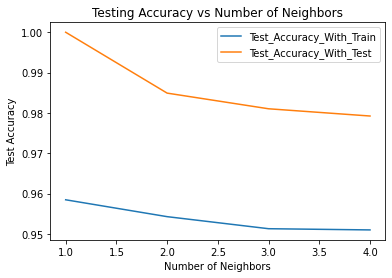

In [20]:
###### Testing Model - ArcFace Style                
with tpu_strategy.scope():     

    def normalisation_layer(x):   
        return(tf.math.l2_normalize(x, axis=1, epsilon=1e-12))

    #X_dev_flipped = tf.image.flip_up_down(X_dev)  
    #x_train_flipped = tf.image.flip_up_down(X_train_final)

    predictive_model = tf.keras.models.Model(inputs=model.input,outputs=model.layers[-3].output)
    predictive_model.compile(tf.keras.optimizers.Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

with tpu_strategy.scope():
    y_in = tf.keras.layers.Input((47,))

    Input_Layer = tf.keras.layers.Input((1280,1))
    op_1 = predictive_model([Input_Layer,y_in])

    ##Input_Layer_Flipped = tf.keras.layers.Input((224,224,3))
    ##op_2 = predictive_model([Input_Layer_Flipped,y_in]) 
    ##final_op = tf.keras.layers.Concatenate(axis=1)(op_1)

    final_norm_op = tf.keras.layers.Lambda(normalisation_layer)(op_1)

    testing_model = tf.keras.models.Model(inputs=[Input_Layer,y_in],outputs=final_norm_op)
    testing_model.compile(tf.keras.optimizers.Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

##### Nearest Neighbor Classification
from sklearn.neighbors import KNeighborsClassifier
#Test_Embeddings = testing_model.predict((X_dev,y_dev_ohot))
#Train_Embeddings = testing_model.predict((X_train,y_train_ohot))

#col_mean = np.nanmean(Test_Embeddings, axis=0)
#inds = np.where(np.isnan(Test_Embeddings))
#print(inds)
#Test_Embeddings[inds] = np.take(col_mean, inds[1])

#col_mean = np.nanmean(Train_Embeddings, axis=0)                                                                                                                                
#inds = np.where(np.isnan(Train_Embeddings))
#print(inds)
#Train_Embeddings[inds] = np.take(col_mean, inds[1])

#Test_Embeddings = np.nan_to_num(Test_Embeddings)

##### Refining Test Embeddings
#for i in range(Train_Embeddings.shape[0]):
#    for j in range(Train_Embeddings.shape[1]):
#        if(math.isnan(Train_Embeddings[i,j])):
#            Train_Embeddings[i,j] == 0
#        if(Train_Embeddings[i,j]>1e4):
#            Train_Embeddings[i,j] == 1e4

##### Refining Train Embeddings    
#for i in range(Test_Embeddings.shape[0]):
#    for j in range(Test_Embeddings.shape[1]):
#        if(math.isnan(Test_Embeddings[i,j])):
#            Test_Embeddings[i,j] == 0
#        if(Test_Embeddings[i,j]>1e4 or math.isinf(Test_Embeddings[i,j])):
#            Test_Embeddings[i,j] == 1e4

#del(X_train_final,X_dev,X_dev_flipped,x_train_flipped)
#gc.collect()

Test_Accuracy_With_Train = []
Test_Accuracy_With_Test = []
                                                                     
for k in range(1,5):
    knn = KNeighborsClassifier(n_neighbors=k,metric='euclidean')
    knn.fit(Train_Embeddings,y_train)
    Test_Accuracy_With_Train.append(knn.score(Test_Embeddings,y_dev))
    knn.fit(Test_Embeddings,y_dev)
    Test_Accuracy_With_Test.append(knn.score(Test_Embeddings,y_dev))

print('--------------------------------')
print(np.max(Test_Accuracy_With_Train))
print(np.max(Test_Accuracy_With_Test))
print('--------------------------------')
print(np.mean(Test_Accuracy_With_Train))
print(np.mean(Test_Accuracy_With_Test))
print('--------------------------------')
print((Test_Accuracy_With_Train)[0])
print((Test_Accuracy_With_Test)[0])
print('--------------------------------')

plt.plot(np.arange(1,5),np.array(Test_Accuracy_With_Train),label='Test_Accuracy_With_Train')
plt.plot(np.arange(1,5),np.array(Test_Accuracy_With_Test),label='Test_Accuracy_With_Test')
plt.title('Testing Accuracy vs Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Test Accuracy')
plt.legend()       
plt.show()                 

np.savez_compressed('Test_Embeddings_Baseline.npz',Test_Embeddings)
np.savez_compressed('Train_Embeddings_Baseline.npz',Train_Embeddings)

## t-SNE

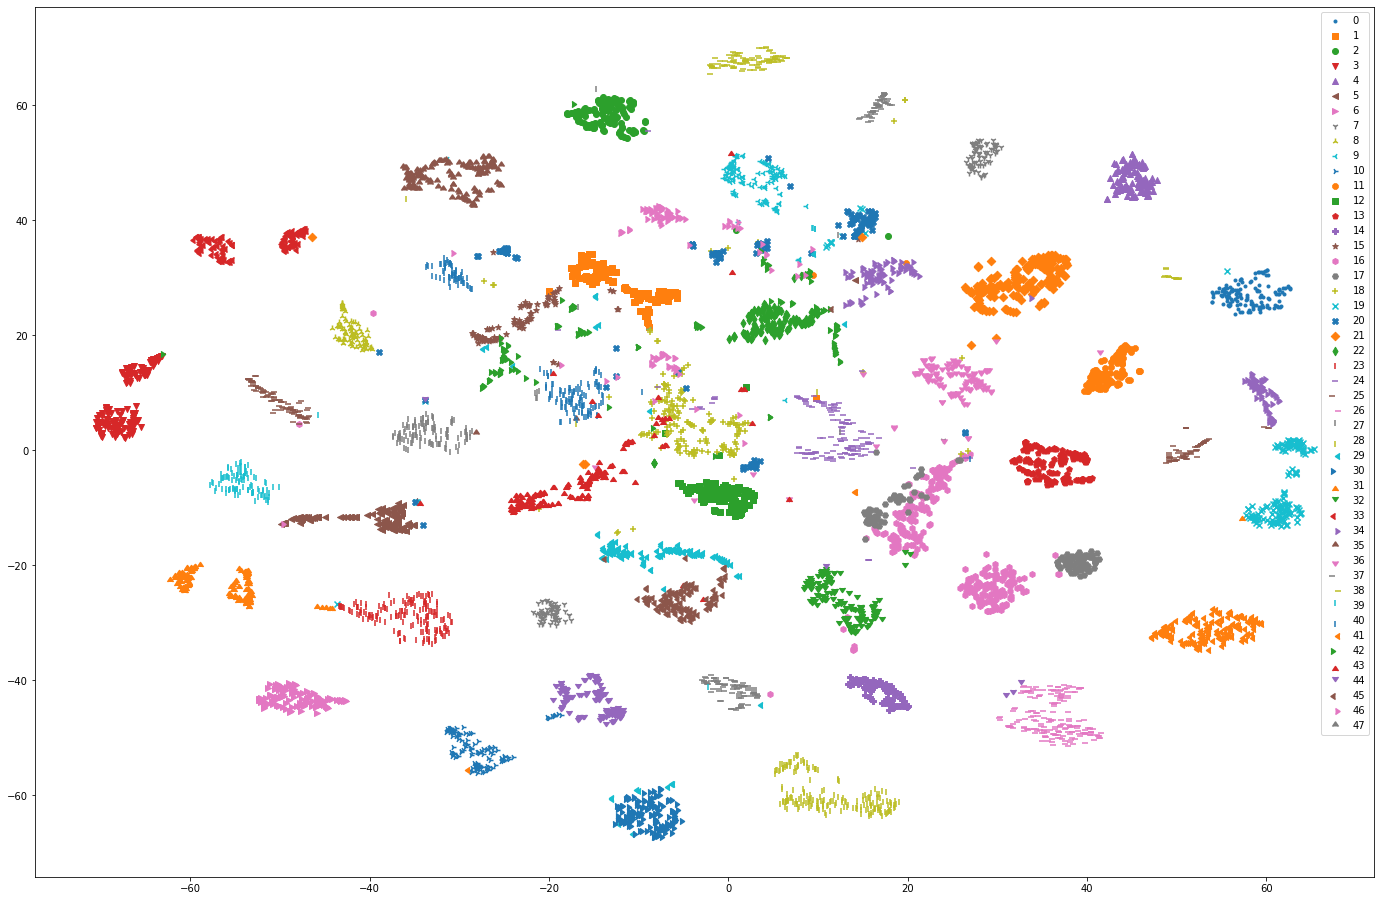

In [21]:
####### t-SNE Plot Generation
###### Model Creation
#with tpu_strategy.scope():          
#    tsne_model = tf.keras.models.Model(inputs=model.input,outputs=model.layers[-4].output)
#    tsne_model.compile(tf.keras.optimizers.Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
#tsne_model.summary()

###### Model Predicted
#embeddings_final = tsne_model.predict((X_dev,y_exp))

###### t-SNE plot plotting
##### Reduction to Lower Dimensions
tsne_X_dev = TSNE(n_components=2,perplexity=30,learning_rate=10,n_iter=2000,n_iter_without_progress=50).fit_transform(Test_Embeddings)

##### Plotting
j = 0 # Index for rotating legend
plt.rcParams["figure.figsize"] = [24,16]
mStyles = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",
           0,1,2,3,4,5,6,7,8,9,10,11,0,1,2,3,4,5,6,7,8,9,10]
for idx,color_index,marker_type in zip(list(np.arange(100)),sns.color_palette('muted',100),mStyles):
    plt.scatter(tsne_X_dev[y_dev == idx, 0], tsne_X_dev[y_dev == idx, 1],marker=marker_type)
plt.legend([str(j) for j in range(100)])
plt.savefig('tsne_plot_5000_iters.png')
plt.savefig('tsne_plot_5000_iters.pdf')
plt.show()